In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import os

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy.stats as stats

import seaborn as sns

from datetime import datetime

import re

from tqdm.notebook import tqdm

import dask.dataframe as dd
from dask.distributed import Client

sys.path.insert(0, 'tools/')

from tools import * 

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 5
Total threads: 20,Total memory: 31.04 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38269,Workers: 5
Dashboard: http://127.0.0.1:8787/status,Total threads: 20
Started: Just now,Total memory: 31.04 GiB
Comm: tcp://127.0.0.1:44397,Total threads: 4
Dashboard: http://127.0.0.1:41423/status,Memory: 6.21 GiB
Nanny: tcp://127.0.0.1:33641,


# Merge

In [3]:
config = pd.Series({
    'path': os.path.abspath('dades'),
    'file_type':'csv',
    'years':[2019, 2021, 2022],
    'dataset': 'BicingNou_ESTACIONS_MOD'
})

In [4]:
%%time

def read_data_all(cnfg:dict):

    data = dict()

    for year in cnfg.years:
        cnfg['year'] = year
        data[year] = load_checkpoint(cnfg)
    
    return dd.concat(list(data.values()), interleave_partitions=False)
    
bbdd_completa = read_data_all(config)   

checkpoint reloaded.
checkpoint reloaded.
checkpoint reloaded.
CPU times: user 52.3 ms, sys: 4.65 ms, total: 56.9 ms
Wall time: 54.5 ms


In [5]:
%%time

index=0
before = get_ddf_shape(bbdd_completa)
print(before)

index+=1
print(index)
# 1 Error fix. # 2019 gener, febrer and marc have the status reversed
cond = (bbdd_completa.year == 2019) & (bbdd_completa.month.isin([1,2,3]))
bbdd_completa['status'] = bbdd_completa['status'].mask(cond, ((bbdd_completa['status'] + 1) %2))
index+=1
print(index)
# 2 Remove not needed status, manitenance, planned. open = 0, closed = 1 
cond = (bbdd_completa['status'].isin([2.0,3.0]))
bbdd_completa['status'] = bbdd_completa['status'].mask(cond, 1.0)
# bbdd_completa = bbdd_completa.dropna(subset=['status'])
index+=1
print(index)
# 3 Remove data from 2020
cond = (bbdd_completa['year'].isin([2020]))
bbdd_completa = bbdd_completa.mask(cond, np.nan)
bbdd_completa = bbdd_completa.dropna(subset=['year'])
index+=1
print(index)
# 4 2019 to 2020 to have continuos data 
cond = (bbdd_completa['year'].isin([2019]))
bbdd_completa['year'] = bbdd_completa['year'].mask(cond, bbdd_completa['year']+1)
index+=1
print(index)
# 5 status reversed 
bbdd_completa['status'] = (bbdd_completa['status'] + 1)%2
index+=1
print(index)
# 6 Column has all ones
bbdd_completa = bbdd_completa.drop(columns=['is_installed'])
index+=1
print(index)
# 7 Column has all ones
bbdd_completa = bbdd_completa.drop(columns=['is_charging_station'])
index+=1
print(index)
# 8 Remove row where status = closed and is renting and is returning
# cond = (bbdd_completa['status'].isin([0.0])) & (bbdd_completa['is_renting'].isin([1.0])) & (bbdd_completa['is_returning'].isin([1.0]))
# bbdd_completa = bbdd_completa.mask(cond, np.nan)
# bbdd_completa = bbdd_completa.dropna(subset=['status'])

after = get_ddf_shape(bbdd_completa)
print(after)

print('Changes to dataframe durinf preprocessing')
print(f'dropeed {(after[0]-before[0]):02d} rows')
print(f'dropped {(after[1]-before[1]):02d} columns')

(12419994, 23)
1
2
3
4
5
6
7
8
(12419489, 21)
Changes to dataframe durinf preprocessing
dropeed -505 rows
dropped -2 columns
CPU times: user 3.21 s, sys: 273 ms, total: 3.49 s
Wall time: 14.4 s


In [7]:
%%time

unique_ids_by_year = bbdd_completa.groupby('year')['station_id'].unique().compute()
print(unique_ids_by_year)

# Calcula los station_id comunes en todos los años
common_ids = set(unique_ids_by_year[2020])
for year, ids in unique_ids_by_year.items():
    print(year, ids.shape)
    common_ids = common_ids.intersection(set(ids))
# common_ids
print(len(common_ids))

filtered_bbdd = bbdd_completa[bbdd_completa['station_id'].isin(common_ids)]
nonfiltered_bbdd = bbdd_completa[~bbdd_completa['station_id'].isin(common_ids)]

year
2020.0    [1, 320, 319, 318, 317, 316, 315, 314, 313, 31...
2021.0    [1.0, 271.0, 400.0, 510.0, 26.0, 270.0, 269.0,...
2022.0    [1, 380, 28, 379, 378, 377, 376, 375, 29, 374,...
Name: station_id, dtype: object
2020.0 (410,)
2021.0 (509,)
2022.0 (510,)
408
CPU times: user 1.11 s, sys: 93.8 ms, total: 1.2 s
Wall time: 7.55 s


In [8]:
%%time

before = get_ddf_shape(filtered_bbdd)
print(before)

filtered_bbdd = filtered_bbdd.drop_duplicates(subset=['timestamp', 'station_id'], keep='last')

after = get_ddf_shape(filtered_bbdd)
print(after)

print('Changes to dataframe durinf preprocessing')
print(f'dropeed {(after[0]-before[0]):02d} rows')
print(f'dropped {(after[1]-before[1]):02d} columns')

(10627655, 21)
(10526888, 21)
Changes to dataframe durinf preprocessing
dropeed -100767 rows
dropped 00 columns
CPU times: user 5.62 s, sys: 410 ms, total: 6.03 s
Wall time: 23.2 s


In [9]:
%%time

before = get_ddf_shape(nonfiltered_bbdd)
print(before)

nonfiltered_bbdd = nonfiltered_bbdd.drop_duplicates(subset=['timestamp', 'station_id'], keep='last')

after = get_ddf_shape(nonfiltered_bbdd)
print(after)

print('Changes to dataframe durinf preprocessing')
print(f'dropeed {(after[0]-before[0]):02d} rows')
print(f'dropped {(after[1]-before[1]):02d} columns')

(1791834, 21)
(1771494, 21)
Changes to dataframe durinf preprocessing
dropeed -20340 rows
dropped 00 columns
CPU times: user 5.33 s, sys: 406 ms, total: 5.73 s
Wall time: 20.1 s


# Predicción__________________________________
a) Regresión lineal: relación lineal entre las variables de entrada y la variable de salida. 

b) Regresión Redes Neuronales (RNN -redes neuronales recurrentes-): pueden capturar relaciones no lineales entre las variables de entrada y salida.

In [10]:
import os
import csv
import pandas as pd
import random
import numpy as np
import warnings
warnings.simplefilter('ignore')

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import cross_val_score


from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer

from sklearn import neighbors
from sklearn import linear_model
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

DATA_DIR = 'dades'
OUTPUT_DIR = './'

In [12]:
class Config:
    num_attribs0 = ['year', 'ctx1', 'ctx2', 'ctx3', 'ctx4']
    cat_attribs0 = ['month', 'dayofweek', 'day', 'dayofyear', 'hour']
    cat_attribs1 = ['station_id']
    gen_attribs0 = ['status']
    target_col = ['ctx0']
    
    epochs=5
    batch_size=128
    seed=42
    embedding_dim=8
    lr=1e-4

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    

In [13]:
config=Config()
seed_everything(config.seed)

In [14]:
filtered_bbdd.columns

Index(['station_id', 'num_docks_available', 'num_bikes_available', 'status',
       'timestamp', 'is_renting', 'is_returning',
       'num_bikes_available_types.mechanical',
       'num_bikes_available_types.ebike', 'year', 'month', 'dayofweek', 'day',
       'dayofyear', 'hour', 'capacity', 'ctx0', 'ctx1', 'ctx2', 'ctx3',
       'ctx4'],
      dtype='object')

In [15]:

def build_preprocessor(config): 
    num_attribs0 = config.num_attribs0 # ['year', 'ctx1', 'ctx2', 'ctx3', 'ctx4']
    cat_attribs0 = config.cat_attribs0 #['month', 'dayofweek', 'day', 'dayofyear', 'hour' ]
    cat_attribs1 = config.cat_attribs1 #['station_id']
    gen_attribs0 = config.gen_attribs0 #['status']
    
    num_transformer0 = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ('std_scaler', (StandardScaler())),
    ])

    categorical_transformer0 = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="constant",fill_value=0)),
        ('ordinal_encoder', (OrdinalEncoder())),
    ])
    
    categorical_transformer1 = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="constant",fill_value=0)),
        ('one_hot_encoder', (OneHotEncoder(handle_unknown='ignore'))),
    ])
    
    generic_transformer0 = Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ("num0", num_transformer0, num_attribs0),
            ("gen1", generic_transformer0, gen_attribs0),
            ("cat0", categorical_transformer0, cat_attribs0),
            ("cat1", categorical_transformer1, cat_attribs1),
        ],
        remainder="drop"
    )
    
    return preprocessor

def apply_pipeline(config, x_train,x_test,y_train,y_test, show=True):
    
    full_pipeline = build_preprocessor(config)

    x_train_prepared = full_pipeline.fit_transform(x_train)
    x_test_prepared = full_pipeline.transform(x_test)
    
    if show:
        print("x_train_prepared:",x_train_prepared.shape,"y_train: ",y_train.shape)
        print("x_test_prepared:",x_test_prepared.shape,"y_test: ",y_test.shape)

    return x_train_prepared,x_test_prepared,y_train,y_test


In [16]:
train_data2020 = filtered_bbdd[filtered_bbdd.year.isin([2022])]
get_ddf_shape(train_data2020)

(3541851, 21)

In [17]:
test_data2020 = nonfiltered_bbdd[nonfiltered_bbdd.year.isin([2022])]
get_ddf_shape(test_data2020)

(882910, 21)

In [18]:
%%time 

x_train, x_test, y_train, y_test = train_data2020.compute().copy(),test_data2020.compute().copy(), train_data2020.ctx0.compute().copy(), test_data2020.ctx0.compute().copy()


2023-06-04 19:51:25,663 - distributed.worker.memory - WARNING - Worker is at 87% memory usage. Pausing worker.  Process memory: 5.42 GiB -- Worker memory limit: 6.21 GiB
2023-06-04 19:51:25,794 - distributed.worker.memory - WARNING - Worker is at 30% memory usage. Resuming worker. Process memory: 1.88 GiB -- Worker memory limit: 6.21 GiB


CPU times: user 6.45 s, sys: 1.56 s, total: 8.01 s
Wall time: 48 s


In [19]:
%%time 

x_train_prepared,x_test_prepared,y_train,y_test = apply_pipeline(config, x_train,x_test,y_train,y_test)

x_train_prepared: (3541851, 419) y_train:  (3541851,)
x_test_prepared: (882910, 419) y_test:  (882910,)
CPU times: user 3.69 s, sys: 564 ms, total: 4.25 s
Wall time: 3.89 s


In [20]:
%%time 

lin_reg = LinearRegression()
cross_val_evaluation(lin_reg,x_train_prepared, y_train,'Linear Regression')
#  Linear Regression
# Scores: [0.86876116 0.85690033 0.83716171 0.82008556 0.8135665 ]
# Mean: 0.8392950517172396
# Standard deviation: 0.021041440859117303


  Linear Regression
Scores: [0.81367656 0.81719661 0.81319699 0.81493743 0.81635071]
Mean: 0.8150716588055694
Standard deviation: 0.0015251268187717795
CPU times: user 51.3 s, sys: 2min 34s, total: 3min 25s
Wall time: 16.9 s



Training time: 0.098 s
----- EVALUATION ON VAL SET ------
MSE: 0.01261885952667277
RMSE 0.11233369720022915
MAE: 0.07492907714413843
R^2:  0.8151138788519758



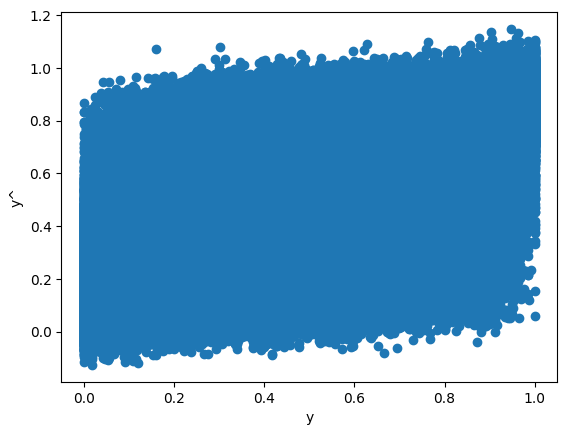


Testing time: 0.014 s
----- EVALUATION ON VAL SET ------
MSE: 0.00922703271634388
RMSE 0.09605744487723937
MAE: 0.06502250682169039
R^2:  0.8580085617143018



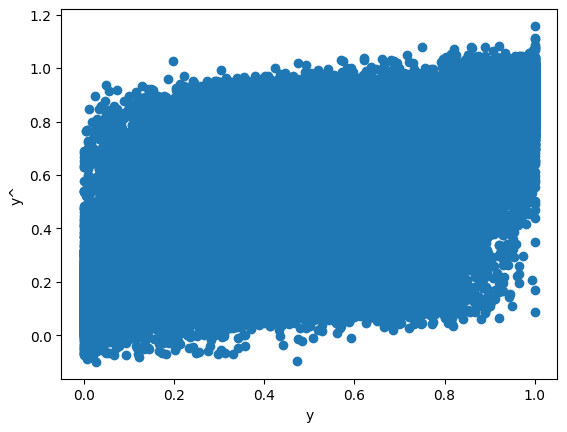

y_hat_t    [0.5934913886212191, 0.5956843753126415, 0.596...
mse_t                                               0.012619
rmse_t                                              0.112334
mae_t                                               0.074929
r2_t                                                0.815114
y_hat_v    [0.8108800990124164, 0.7303344343522489, 0.842...
mse_v                                               0.009227
rmse_v                                              0.096057
mae_v                                               0.065023
r2_v                                                0.858009
dtype: object

In [21]:
lin_reg.fit(x_train_prepared,y_train)
test_model(lin_reg, x_train_prepared, y_train, x_test_prepared, y_test)

In [22]:
%%time 

ridge_reg = linear_model.Ridge(alpha=0.01) # Create a Ridge regressor
cross_val_evaluation(ridge_reg,x_train_prepared, y_train,'Ridge Regression')
#   Ridge Regression
# Scores: [0.86875691 0.85689315 0.83715539 0.82008539 0.81356727]
# Mean: 0.839291622628996
# Standard deviation: 0.021039020876520598


  Ridge Regression
Scores: [0.81364175 0.81717376 0.81316073 0.81491798 0.81631735]
Mean: 0.8150423150711928
Standard deviation: 0.0015288016781132593
CPU times: user 28.8 s, sys: 1min 19s, total: 1min 48s
Wall time: 9.16 s



Training time: 0.066 s
----- EVALUATION ON VAL SET ------
MSE: 0.012618859526765403
RMSE 0.11233369720064146
MAE: 0.07492907288341558
R^2:  0.8151138788506186



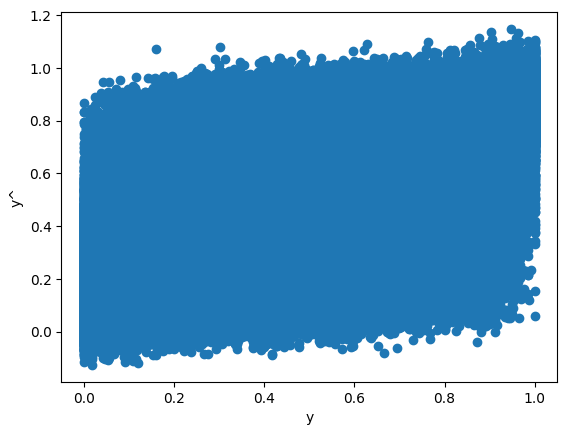


Testing time: 0.015 s
----- EVALUATION ON VAL SET ------
MSE: 0.009227031821400772
RMSE 0.09605744021886474
MAE: 0.06502249569909713
R^2:  0.8580085754862546



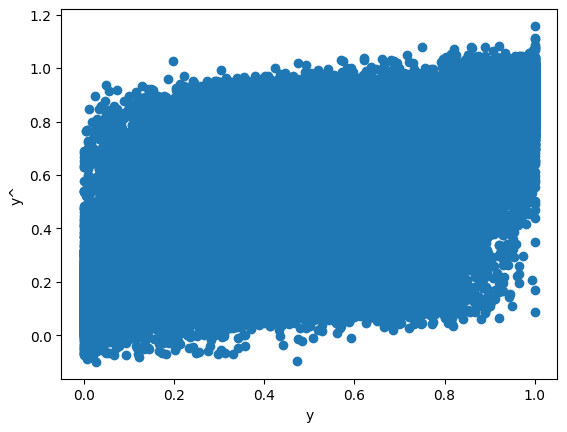

y_hat_t    [0.5934914509169749, 0.5956844313112943, 0.596...
mse_t                                               0.012619
rmse_t                                              0.112334
mae_t                                               0.074929
r2_t                                                0.815114
y_hat_v    [0.8108801675559145, 0.7303345207956573, 0.842...
mse_v                                               0.009227
rmse_v                                              0.096057
mae_v                                               0.065022
r2_v                                                0.858009
dtype: object

In [23]:
ridge_reg.fit(x_train_prepared,y_train)
test_model(ridge_reg, x_train_prepared, y_train, x_test_prepared, y_test)

In [24]:
%%time 

lasso_reg = linear_model.Lasso(alpha=0.01) # Create a Ridge regressor
cross_val_evaluation(lasso_reg,x_train_prepared, y_train,'Lasso Regression')
#   Lasso Regression
# Scores: [0.85542452 0.844529   0.82666133 0.81003802 0.80356838]
# Mean: 0.8280442480533837
# Standard deviation: 0.0197313499648892
# CPU times: user 2min 14s, sys: 3min 2s, total: 5min 16s
# Wall time: 1min 28s


  Lasso Regression
Scores: [0.80106658 0.80428888 0.80048798 0.8019944  0.80376297]
Mean: 0.8023201631809762
Standard deviation: 0.0014827012108497317
CPU times: user 22.2 s, sys: 9.72 s, total: 31.9 s
Wall time: 18.7 s



Training time: 0.046 s
----- EVALUATION ON VAL SET ------
MSE: 0.013491343297615328
RMSE 0.11615224189663895
MAE: 0.07948768164944155
R^2:  0.8023306206000549



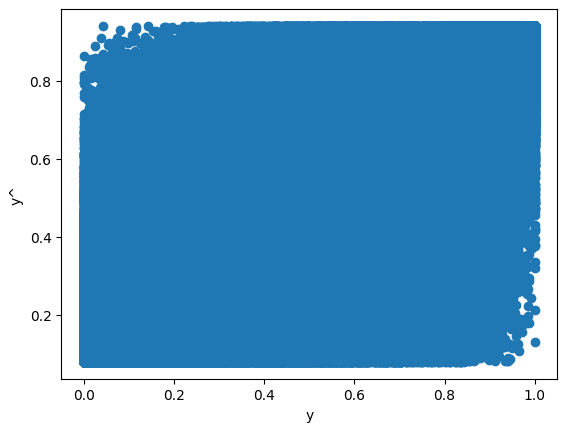


Testing time: 0.01 s
----- EVALUATION ON VAL SET ------
MSE: 0.009762316195603714
RMSE 0.09880443408877819
MAE: 0.06666181370059676
R^2:  0.8497712796489585



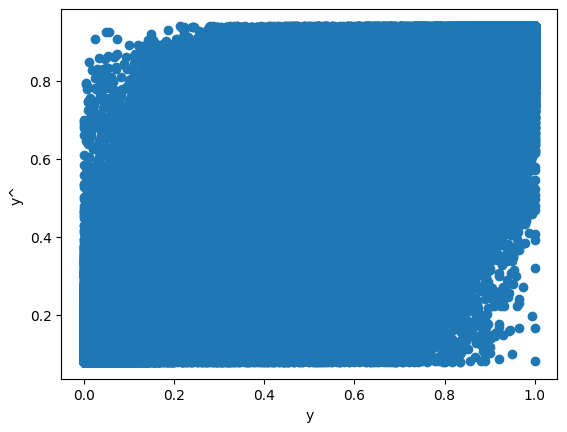

y_hat_t    [0.5837137105671476, 0.5837137105671476, 0.583...
mse_t                                               0.013491
rmse_t                                              0.116152
mae_t                                               0.079488
r2_t                                                0.802331
y_hat_v    [0.8155635765835065, 0.7338436287151212, 0.836...
mse_v                                               0.009762
rmse_v                                              0.098804
mae_v                                               0.066662
r2_v                                                0.849771
dtype: object

In [25]:
lasso_reg.fit(x_train_prepared,y_train)
test_model(lasso_reg, x_train_prepared, y_train, x_test_prepared, y_test)

## KNN3

## SVM 

## Random forest

## Gradiend Boosting